In [12]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from numpy import asarray
from numpy import save
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Học máy/preprocessing-data/csv/datatrain.csv')

In [5]:
dataTest = pd.read_csv('/content/drive/MyDrive/Học máy/preprocessing-data/csv/datatest.csv')

In [6]:
from gensim.models import KeyedVectors 
w2v = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Học máy/LSTM/vi/vi.vec")
vocab = w2v.wv.vocab #Danh sách các từ trong từ điển

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data

,content,lable
0,em quen anh đã lâu có đến 6 7 năm gì đó chứ ít...,0
1,đó là nghệ_thuật mà mỗi cá_nhân đóng vai_trò d...,0
2,đối_với phần_lớn chúng_ta từ bí_mật có một ý_n...,0
3,hoàn_cảnh của tôi giống lài đọc những dòng tâm...,0
4,tạo không_gian mát_mẻ trong mùa hè để làm dịu ...,0
...,...,...
58887,madonna dùng đông_dược mong sinh con ở tuổi 46...,9
58888,phi_nhung hạnh_phúc vì được hát tại quê nhà tô...,9
58889,thanh_bạch nhiều người nhìn mc kiểu vạch lá tì...,9
58890,nhà_văn viết kịch_bản cuộc_chơi tạt ngang và l...,9


In [ ]:
rows = data.shape[0]
import torch
# X = torch.zeros((10000,200,100),device=device)

In [ ]:
# suff = torch.randperm(rows)

In [ ]:
y_test = dataTest['lable']

In [ ]:
Y = data['lable']
# Y = Y.reset_index(drop = True)

In [ ]:
Y = torch.tensor(Y,device=device)

In [ ]:
def convert1(data):
  X = torch.zeros((data.shape[0],200,100),device=device)
  for x in range(X.shape[0]):
      if x %100 ==0:
          print(x)
      words = data.loc[x,('content')].split(" ")
      size = 200
      if len(words) < 200:
          size = len(words)
      tmp = 0
      y = 0
      while(len(words) > y and y<200):
          # print(y)
          if words[y] in vocab:
              X[x][tmp] = torch.tensor(w2v.wv[words[y]],device=device)
              tmp+=1
          y+=1
  return X

In [ ]:
Xtest = convert1(dataTest[:])

23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
25100
25200


In [ ]:
X = convert1(data[:])

In [ ]:
def convert(suff):
  # print(suff.shape)
  X = torch.zeros((suff.shape[0],200,100),device=device)
  Y = np.zeros((suff.shape[0]))
  for x in range(suff.shape[0]):
      Y[x] = data.loc[suff[x].item(),('lable')]
      # print(x)
      words = data.loc[suff[x].item(),('content')].split(" ")
      size = 200
      if len(words) < 200:
          size = len(words)
      tmp = 0
      y = 0
      while(len(words) > y and y<200):
          # print(y)
          if words[y] in vocab:
              X[x][tmp] = torch.tensor(w2v.wv[words[y]],device=device)
              tmp+=1
          y+=1
  return X,torch.tensor(Y,device=device)

In [ ]:
X.shape

torch.Size([58892, 200, 100])

In [13]:
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM,self).__init__()
        
        self.hidden_size = hidden_size        
        self.cct = nn.Linear(input_size + hidden_size,hidden_size)
        self.it = nn.Linear(input_size + hidden_size,hidden_size)
        self.ft = nn.Linear(input_size + hidden_size,hidden_size)
        self.ot = nn.Linear(input_size + hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
    def forward(self,input,hidden,candidate):
        # print(input.device)
        # print(hidden.device)
        combined = torch.cat((input,hidden),dim = 1)
#         print(combined.shape)
        combined = combined.float()
        ft = self.ft(combined)
        ft = self.sigmoid(ft)
        it = self.it(combined)
        it = self.sigmoid(it)
        cct = self.cct(combined)
        cct = self.tanh(cct)
        c_next = it*cct + ft*candidate
        ot = self.ot(combined)
        ot = self.sigmoid(ot)
        a_next = ot * self.tanh(c_next)
        output = self.out(a_next)
        
        output = self.dropout(output)
        output = self.softmax(output)
        return output,a_next,c_next

    def initHidden(self,size):
        return torch.zeros(size, self.hidden_size,device=device)


In [ ]:
def train(X,y,lstm_optimizer,lstmCell):
    size = X.shape[0]
    hidden = lstmCell.initHidden(size)
    cadidate = lstmCell.initHidden(size)
    lstm_optimizer.zero_grad()
    for i in range(200):

        input =  X[:,i,:]
#         print(X.shape)
#         print(input.shape)
#         return
        output,hidden,cadidate = lstmCell(input,hidden,cadidate)
        
    # print(output[0])
    loss = criterion(output, y)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    lstm_optimizer.step()
    return output, loss.item()

In [ ]:
import time
import math
import random



from torch import optim





# Keep track of losses for plotting


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def trainEpoch(lstmCell,X_train,y_train,lstm_optimizer,criterion):
    epochs = 15
    print_every = 100
    plot_every = 200
    batch_size = 64
    
    current_loss = 0
    all_losses = []

    start = time.time()
    res = 0
    rows = data.shape[0]
    # print(rows)
    for epoch in range(epochs):
        print('epoch: ',epoch)
        tmp = int(rows/batch_size + 0.5)
        suff = torch.randperm(rows)
        
        for x in range(tmp):
            if batch_size*(x+1)>rows:
                X1 = convert(suff[batch_size*x:rows])
                Y1 = y_train[suff][batch_size*x:rows].to(device)
                output, loss = train(X1, Y1,lstm_optimizer,lstmCell)
            else:
                size = torch.tensor(batch_size,device=device)
                X1 = convert(suff[batch_size*x:batch_size*(x+1)])
                Y1 = y_train[suff][batch_size*x:batch_size*(x+1)].to(device)
                output, loss = train(X1, Y1,lstm_optimizer,lstmCell)
            current_loss += loss

        # Print iter number, loss, name and guess
            if x % print_every == 0:
    #             guess = categoryFromOutput(output)
                print("\n")
        #         correct = '✓' if guess == y_train[x] else '✗ (%s)' % y_train[x].item()
                print('%d %d%% (%s) %.4f  ' % (batch_size*x, batch_size*x / rows * 100, timeSince(start), loss))
            if x % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
    return all_losses

In [ ]:
def trainEpoch1(lstmCell,X_train,y_train,lstm_optimizer,criterion):
    epochs = 51
    print_every = 100
    plot_every = 20
    batch_size = 64
    
    current_loss = 0
    all_losses = []

    start = time.time()
    res = 0
    rows = X_train.shape[0]
    # print(rows)
    for epoch in range(epochs):
        print('epoch: ',epoch)
        tmp = int(rows/batch_size + 0.5)
        suff = torch.randperm(rows)
        
        for x in range(tmp):
            # X1 = 0
            # Y1 = 0
            if batch_size*(x+1)>rows:
                X1 = X_train[suff][batch_size*x:rows].to(device)
                Y1 = y_train[suff][batch_size*x:rows].to(device)
                output, loss = train(X1, Y1,lstm_optimizer,lstmCell)
            else:
                # size = torch.tensor(batch_size,device=device)
                X1 = X_train[suff][batch_size*x:batch_size*(x+1)].to(device)
                Y1 = y_train[suff][batch_size*x:batch_size*(x+1)].to(device)
                output, loss = train(X1, Y1,lstm_optimizer,lstmCell)
            current_loss += loss

        # Print iter number, loss, name and guess
            if x % print_every == 0:
    #             guess = categoryFromOutput(output)
                print("\n")
        #         correct = '✓' if guess == y_train[x] else '✗ (%s)' % y_train[x].item()
                print('%d %d%% (%s) %.4f  ' % (batch_size*x, batch_size*x / rows * 100, timeSince(start), loss))


        all_losses.append(current_loss / rows)
        current_loss = 0
        if epoch % 10 ==0:
          f = open("/content/drive/MyDrive/Học máy/LSTM/listLoss.txt", "a")
          for x in all_losses:
              f.write(str(x) + " ")
          f.close()
          all_losses = []
          torch.save({
            'epoch': 500,
            'model_state_dict': lstmCell.state_dict(),
            'optimizer_state_dict': lstm_optimizer.state_dict(),


            }, "/content/drive/MyDrive/Học máy/LSTM/lstmCell.pth")
    return 0

In [14]:
import torch
n_letter = 100
n_hidden = 128
n_category = 10

lstm = LSTM(n_letter,n_hidden,n_category).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
learning_rate = 0.05
lstm_optimizer = optim.Adagrad(lstm.parameters(), lr=learning_rate,initial_accumulator_value=0.1)
# optim.Adagrad(lstm.parameters(), lr=learning_rate,initial_accumulator_value=0.1)

# learning_rate = 0.01
# lstm_optimizer = optim.SGD(lstm.parameters(), lr=learning_rate, momentum=0.9)


In [ ]:
torch.cuda.empty_cache()
trainEpoch1(lstm,X,Y,lstm_optimizer,criterion)

In [7]:
f = open("/content/drive/MyDrive/Học máy/LSTM/listLoss.txt")
x = f.readline()
x = x.split(" ")

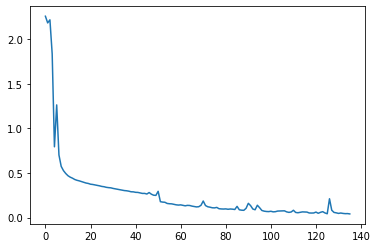

In [9]:
x = x[0:-1]
ls_all = []
for res in x:
    ls_all.append(float(res))
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(ls_all)

In [15]:

torch.save({
            'epoch': 500,
            'model_state_dict': lstm.state_dict(),
            'optimizer_state_dict': lstm_optimizer.state_dict(),


            }, "/content/drive/MyDrive/Học máy/LSTM/lstmCell.pth")

In [16]:
#load model
n_letter = 100
n_hidden = 128
n_category = 10
learning_rate = 0.05

lstm = LSTM(n_letter,n_hidden,n_category).to(device)
lstm_optimizer = optim.Adagrad(lstm.parameters(), lr=learning_rate,initial_accumulator_value=0.1)

checkpoint = torch.load("/content/drive/MyDrive/Học máy/LSTM/lstmCell.pth")
lstm.load_state_dict(checkpoint['model_state_dict'])
lstm_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

lstm.eval()
# - or -
# model.train()

LSTM(
  (cct): Linear(in_features=228, out_features=128, bias=True)
  (it): Linear(in_features=228, out_features=128, bias=True)
  (ft): Linear(in_features=228, out_features=128, bias=True)
  (ot): Linear(in_features=228, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
def predict(X_test,lstmCell):
    with torch.no_grad():

        size = X_test.shape[0]
        hidden = lstmCell.initHidden(size)
        cadidate = lstmCell.initHidden(size)
        lstm_optimizer.zero_grad()
        for i in range(200):

            input =  X_test[:,i,:]
    #         print(X.shape)
    #         print(input.shape)
    #         return
            output,hidden,cadidate = lstmCell(input,hidden,cadidate)
        y_pred = torch.argmax(output,dim=1)
    return y_pred

In [ ]:
y_pred = predict(Xtest,lstm)

In [ ]:
y_pred

tensor([0, 0, 0,  ..., 9, 9, 9], device='cuda:0')

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,y_pred.cpu(),average=None)*100

In [ ]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_test,y_pred.cpu(),average=None)*100

In [ ]:
rc = recall_score(y_test,y_pred.cpu(),average=None)*100

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
f1 = np.round(f1,2)
ps = np.round(ps,2)
rc = np.round(rc,2)

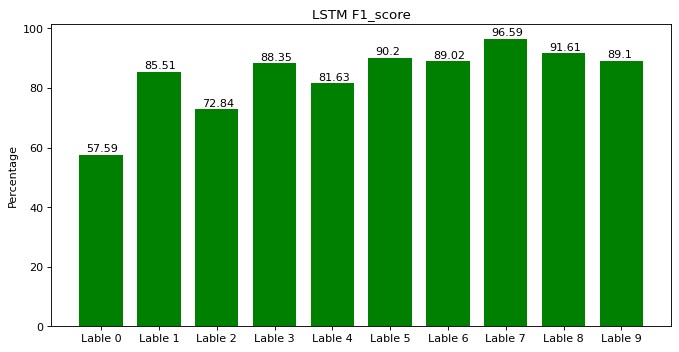

In [ ]:
divisions = ["Lable 0","Lable 1","Lable 2","Lable 3","Lable 4","Lable 5","Lable 6","Lable 7","Lable 8","Lable 9"]


plt.figure(figsize=(10,5), dpi=80)
index = np.arange(0,20,2)
plt.bar(index,f1,width=1.5,color='green',label='F1_score')

plt.xticks(index,divisions)
for index, value in enumerate(f1):
    plt.text(index*2-0.5, value+1,
             str(value))

plt.ylabel('Percentage')
# plt.xlabel('Recall_score')
plt.title('LSTM F1_score')

plt.savefig('LSTM F1_score.png')
plt.show()

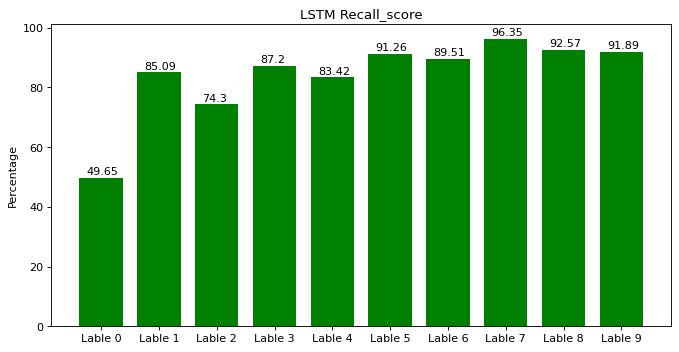

In [ ]:
divisions = ["Lable 0","Lable 1","Lable 2","Lable 3","Lable 4","Lable 5","Lable 6","Lable 7","Lable 8","Lable 9"]


plt.figure(figsize=(10,5), dpi=80)
index = np.arange(0,20,2)
plt.bar(index,rc,width=1.5,color='green',label='F1_score')

plt.xticks(index,divisions)
for index, value in enumerate(rc):
    plt.text(index*2-0.5, value+1,
             str(value))

plt.ylabel('Percentage')
# plt.xlabel('Recall_score')
plt.title('LSTM Recall_score')

plt.savefig('LSTM Recall_score.png')
plt.show()

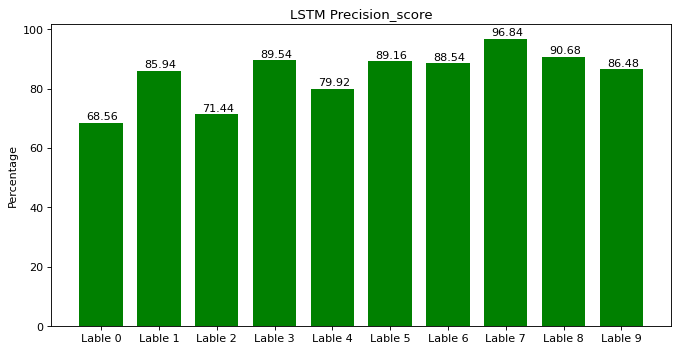

In [ ]:
divisions = ["Lable 0","Lable 1","Lable 2","Lable 3","Lable 4","Lable 5","Lable 6","Lable 7","Lable 8","Lable 9"]


plt.figure(figsize=(10,5), dpi=80)
index = np.arange(0,20,2)
plt.bar(index,ps,width=1.5,color='green',label='F1_score')

plt.xticks(index,divisions)
for index, value in enumerate(ps):
    plt.text(index*2-0.5, value+1,
             str(value))

plt.ylabel('Percentage')
# plt.xlabel('Recall_score')
plt.title('LSTM Precision_score')

plt.savefig('LSTM Precision_score.png')
plt.show()